## Regression task

Choose explanatory variables suitable for the situation (justify your choice), create a regression model and evaluate the goodness of the model.

Chosen dataset: Factors affecting energy efficiency (regression) ENB2012_data.xlsx

Source: https://archive.ics.uci.edu/ml/datasets/Energy+efficiency

Data is opened as follows: df=pd.read_excel('ENB2012_data.xlsx')

Select as the variable to explain the following: Y1 or Y2.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from ucimlrepo import fetch_ucirepo

In [2]:
energy_efficiency = fetch_ucirepo(id=242) 
  
# data (as pandas dataframes) 
X = energy_efficiency.data.features 
y = energy_efficiency.data.targets 
  
# variable information 
print(energy_efficiency.variables) 

  name     role        type demographic                description units  \
0   X1  Feature  Continuous        None       Relative Compactness  None   
1   X2  Feature  Continuous        None               Surface Area  None   
2   X3  Feature  Continuous        None                  Wall Area  None   
3   X4  Feature  Continuous        None                  Roof Area  None   
4   X5  Feature  Continuous        None             Overall Height  None   
5   X6  Feature     Integer        None                Orientation  None   
6   X7  Feature  Continuous        None               Glazing Area  None   
7   X8  Feature     Integer        None  Glazing Area Distribution  None   
8   Y1   Target  Continuous        None               Heating Load  None   
9   Y2   Target  Continuous        None               Cooling Load  None   

  missing_values  
0             no  
1             no  
2             no  
3             no  
4             no  
5             no  
6             no  
7          

## Choice of explanatory variables

I choose Heating Load (Y1) as the target
All the features look suitable for prediction the target, as all of them might be related to heating load.
I am also including categorical features with one-hot encoding.

In [3]:
# rename columns according to variable descriptions
X.columns = ['Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area',
            'Overall Height', 'Orientation', 'Glazing Area', 'Glazing Area Distribution']
y.columns = ['Heating Load', 'Cooling Load']

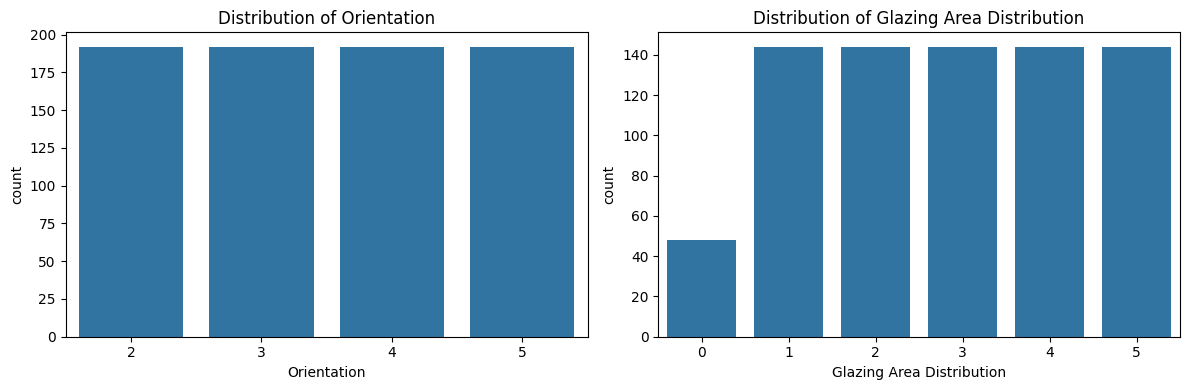

In [4]:
# plot distributions of categorical variables
cat_cols = ['Orientation', 'Glazing Area Distribution']
fig = plt.figure(figsize=(12, 4))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    sns.countplot(x=cat_cols[i], data=energy_efficiency.data.features)
    plt.title(f'Distribution of {cat_cols[i]}')
plt.tight_layout()
plt.show()

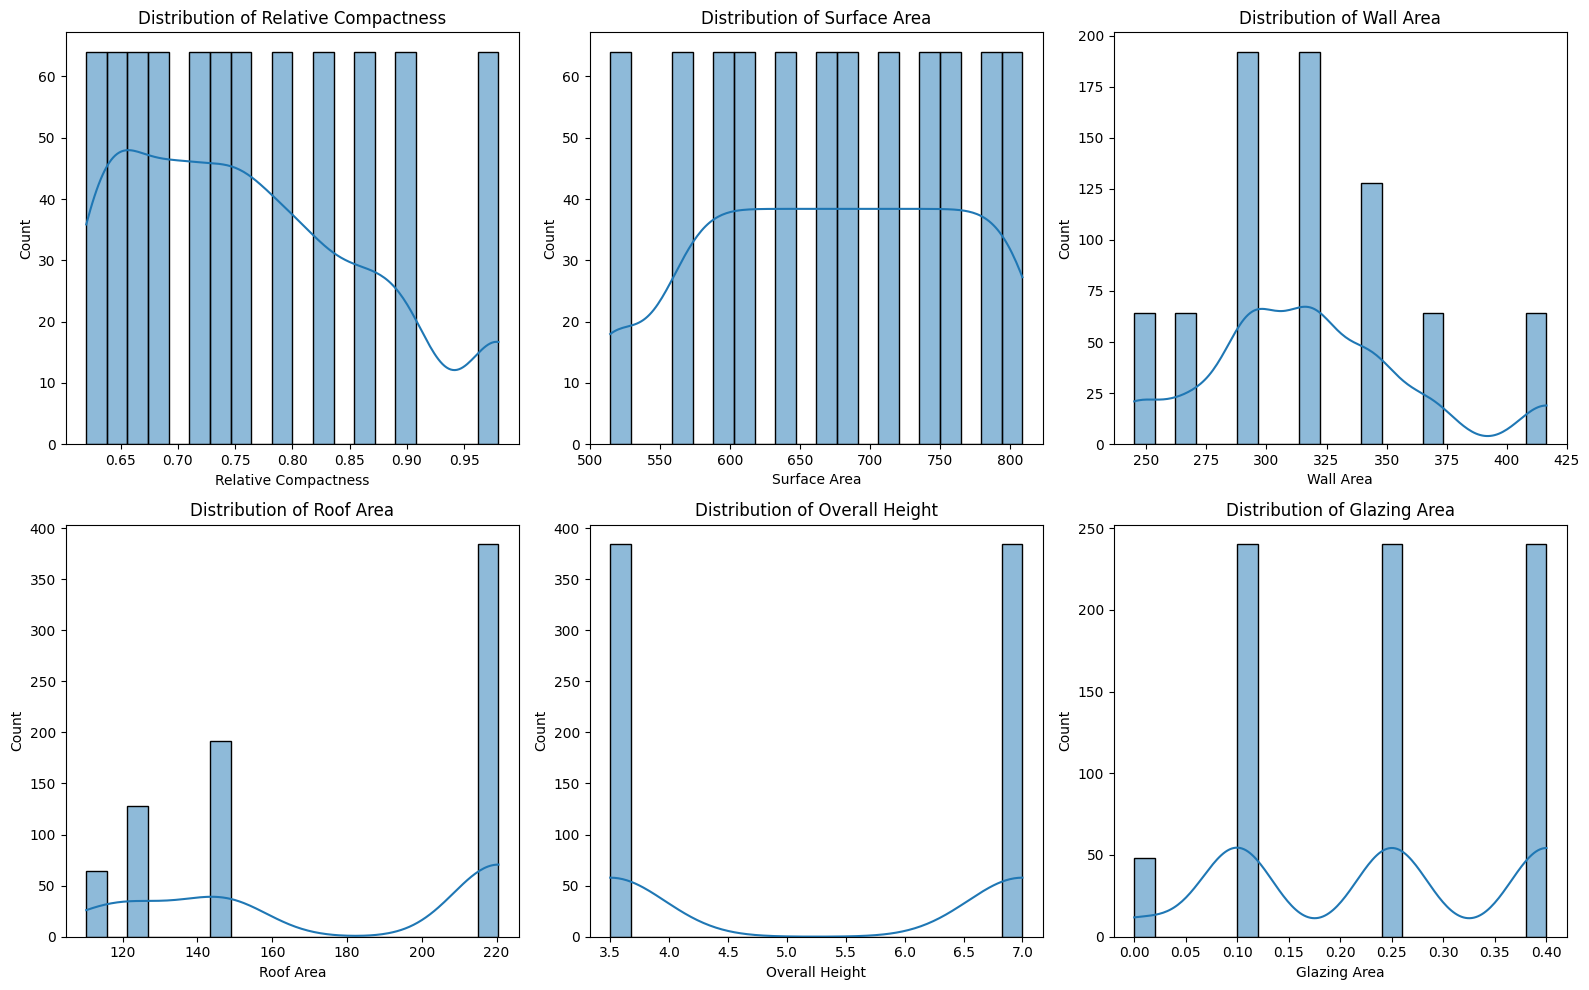

In [5]:
# plot distributions of numerical variables
num_cols = ['Relative Compactness', 'Surface Area', 'Wall Area', 'Roof Area',
            'Overall Height', 'Glazing Area']
fig = plt.figure(figsize=(16, 10))
for i in range(len(num_cols)):
    plt.subplot(2, 3, i + 1)
    sns.histplot(energy_efficiency.data.features[num_cols[i]], bins=20, kde=True)
    plt.title(f'Distribution of {num_cols[i]}')
plt.tight_layout()
plt.show()


## Preprocessing

In [6]:
# one-hot encoding of categorical variables
X = pd.get_dummies(X, columns=['Orientation', 'Glazing Area Distribution'], drop_first=True)
y = y['Heating Load']

In [7]:
# standardize the explanatory variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Model training: Linear Regression

In [8]:
# create and train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [9]:
# make predictions
y_pred = model.predict(X_test)

# evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", round(mse, 2))
print("R-squared:", round(r2, 2))

Mean Squared Error: 8.25
R-squared: 0.92


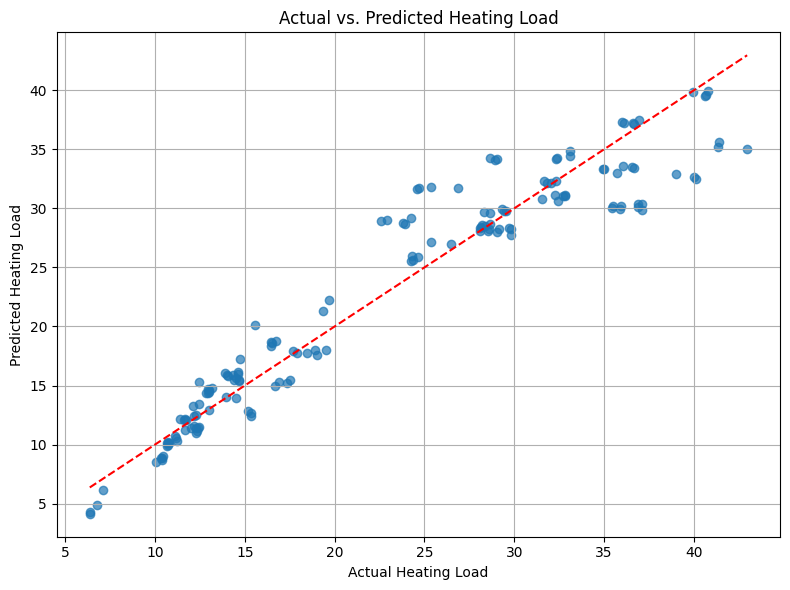

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Heating Load')
plt.ylabel('Predicted Heating Load')
plt.title('Actual vs. Predicted Heating Load')
plt.grid(True)
plt.tight_layout()
plt.show()

## Model training: Random Forest Regressor

In [11]:
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [12]:
y_pred_rf = model_rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Mean Squared Error:", round(mse_rf, 2))
print("R-squared:", round(r2_rf, 2))

Mean Squared Error: 0.28
R-squared: 1.0


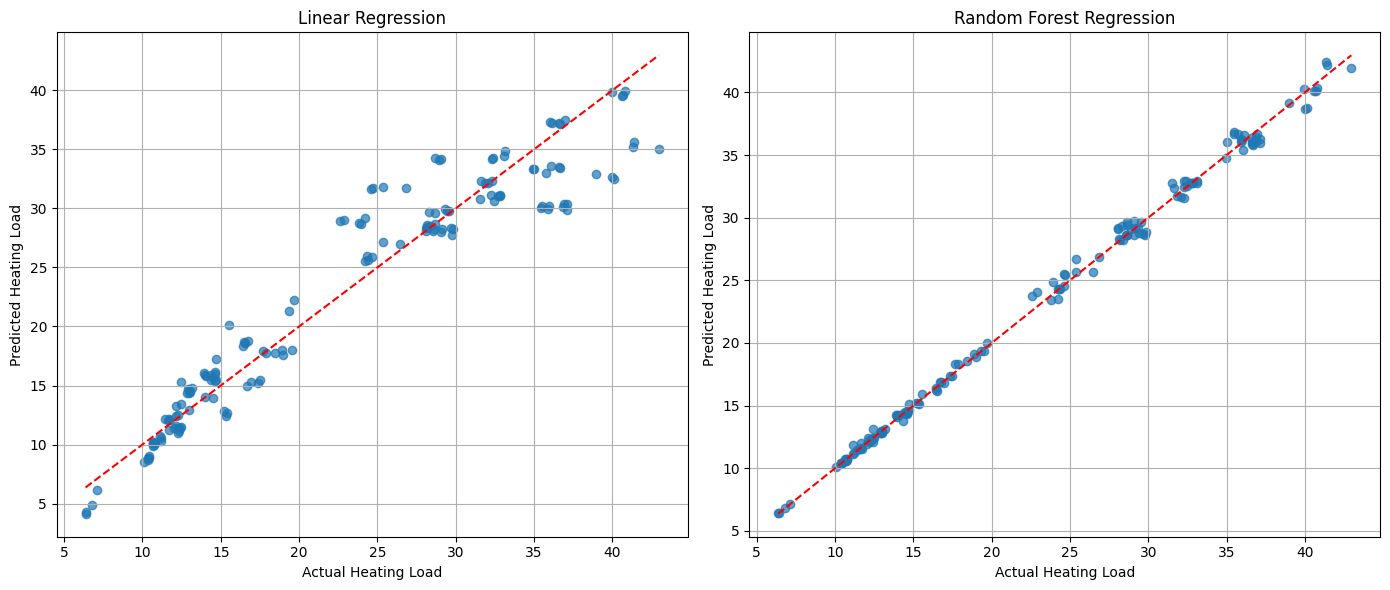

In [13]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Heating Load')
plt.ylabel('Predicted Heating Load')
plt.title('Linear Regression')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Heating Load')
plt.ylabel('Predicted Heating Load')
plt.title('Random Forest Regression')
plt.grid(True)

plt.tight_layout()
plt.show()


R^2 = 1.0 for Random Forest means it's almost perfectly fitting the test data.
MSE = 0.28 is also much lower than that of linear regression.

Random Forest performs much better in this case because the relationship between input features and heating load is not purely linear. 

At the same time RF often tends to overfit. Even though the test data was not seen by the model during training, it may be too similar to training data — especially in low-dimensional datasets like this one.

## Cross-Validation

Check R-squared score in cross-validation to get more fair results.

In [14]:
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(n_splits=10, shuffle=True, random_state=42)

lr = LinearRegression()
lr_scores = cross_val_score(lr, X_scaled, y, cv=cv, scoring='r2')
print("Linear Regression CV R^2: Mean =", round(lr_scores.mean(), 3), ", Std =", round(lr_scores.std(), 3))

Linear Regression CV R^2: Mean = 0.921 , Std = 0.014


In [15]:
rf = RandomForestRegressor(random_state=42)
rf_scores = cross_val_score(rf, X_scaled, y, cv=cv, scoring='r2')
print("Random Forest CV R^2: Mean =", round(rf_scores.mean(), 3), ", Std =", round(rf_scores.std(), 3))

Random Forest CV R^2: Mean = 0.997 , Std = 0.0
